# Ignore
#### Naive Bayes (assume each text only has one topic, will try this and see how bad)
$$
\begin{align}
topic=&argmax_{topic_i} p(words|topic_i)p(topic_i)\\
=&argmax_{topic_i} p(word1|topic_i)p(word2|topic_i)...|p(topic_i)\\
=&argmax_{topic_i} \sum_{word_j} log p(word_j|topic_i)|p(topic_i)
\end{align}
$$

#### Better approach
Since we used LDA, probably better finding topic mixture for each given document. + One research paper can include multiple domains <br>
Get the topic assignment for every word in the new document -> the distribution of topics in that document. <br>
For each document:
we know: W, the text <br>
Unknown: $\phi$, distribution over words for each topic (but we will use what we had for $\bm{\beta}$ from training our LDA model, SparkML Rstudio says orignially use $\bm{\beta}$, bu later paper uses $\phi$ [https://spark.rstudio.com/reference/ml_lda]. Blei extends $\bm{\beta}$ as a random varible drawn from a Dirichlet distirbution for smoothing purpose)<br> 
&emsp;&emsp; &emsp; &emsp;$z$ latent variable, topic of each word <br>
&emsp;&emsp; &emsp; &emsp;$\bm{\theta}$ latent variables, distribution over topics for each document<br>
Goal: find z that maximzes $p(\bm{z}|\bm{w}) -> p(\bm{w}|\bm{z})$

#### MCMC using Gibbs Sampling
Find the conditional probability distribution of a single word’s topic assignment conditioned on the rest of the topic assignments.<br>
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{\alpha},\bm{\beta},\bm{w}) =& \frac{p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})} \\
 &\propto p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta}) \\
 &\propto P(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) 
\end{align} $$

$$
\begin{align}
p(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) =& \int p(\bm{z},\bm{w},\bm{\theta}|\bm{\alpha},\bm{\beta})d\bm{\theta}\\
=& \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) p(\bm{w}|\bm{\beta}_{\bm{z}}) d\bm{\theta} \\
= & p(\bm{w}|\bm{\beta}_{\bm{z}}) \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta}, 
\end{align}$$
where
$$
\begin{align}
p(\bm{w}|\bm{\beta}_{\bm{z}}) = \prod_{j} {\bm{\beta}_{z_j,w_j}}.
\end{align}
$$
Expand the integral term:<br>
The 1st term is: $$ p(\bm{z}|\bm{\theta})= \prod_i \bm{\theta}_{z_i}.$$
The 2nd term is:
$$
\begin{align}
p(\bm{\theta}|\bm{\alpha}) = Dir(\bm{\theta},\bm{\alpha}) = \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1},
\end{align}
$$
where $N$ is the number of topics, and $\frac{1}{\Beta(\alpha)}$, the normalization constant is given by the multivariate beta function and comupted from gamma function as
$$\Beta(\bm{\alpha}) = \frac{\prod_{k=1}^{k=N}\Gamma(\alpha_k)}{\Gamma(\sum_{k=1}^{k=N}\alpha_k)}.$$

Plug in these two terms into the integral term:
$$
\begin{align}
\int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta} =& \int \prod_i \bm{\theta}_{z_i} \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_i \bm{\theta}_{z_i} \prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \hskip{0.5 in} (n_k =\textrm{ the number of times }z_i=k)\textrm{, and define }\bm{n} = [n_1,n_2,...,n_k] \\
= & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int \frac{1}{\Beta(\bm{\alpha}+\bm{n})} \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int Dir(\bm{\theta},\bm{\alpha}+\bm{n}) d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})}
\end{align}
$$
Thus 
$$ 
p(\bm{w},\bm{z}|\bm{\alpha},\bm{\beta})=\frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}}.
$$
Conditional distribution for how to draw topic $z_i$ for word $w_i$:
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta}) =& \frac{p(\bm{z},\bm{w}|,\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|,\bm{\alpha},\bm{\beta})}\\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}} / \frac{\Beta(\bm{\alpha}+\bm{n_{-i}})}{\Beta(\bm{\alpha})} \prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} \\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\frac{\prod_{j} {\bm{\beta}_{z_j,w_j}} }{\prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} }\\
\propto & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\bm{\beta}_{z_i,w_i}\\
\propto & \frac{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n})_k)}{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n})_k)} \frac{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n_{-i}})_k)}{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n_{-i}})_k)} \bm{\beta}_{z_i,w_i}
\end{align} $$


The sampling process is:
* Initailize $\bm{z}$
* while not max_iteration/not converged:
    * for each word $w_i$ in $\bm{w}$:
        1. compute  conditional_p = $p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta})$ ( probabily of $z_i=k$ for each topic $k$ from $N$ total topics)
        2. draw $z_i$ from Multinomial(conditional_p)
        3. update $z_i$, save this 
    * estimate $\bm{\theta}$:$$\theta_k = \frac{n_k+\alpha_k}{\sum_{k} n_k+\alpha_k}$$
    * compute $p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta)$:
            $$p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta) = \log p(\bm{\theta}|\bm{\alpha})+ \sum_{i=0}^{len(\bm{w})}\log p(w_i|z_i,\bm{\beta})  +\log p(z_i|\bm{\theta}) = \log p(\bm{\theta}|\bm{\alpha}) +\sum_{i=0}^{len(\bm{w})} \log \beta_{zi,wi} +\log p(z_i|\bm{\theta})            $$



In [ ]:
class GibbsSampler_Predict:
    def __init__(self, n_topics,alpha=0.2,beta=0.1):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.theta = 0
        self.z_vec = 0
        self.w_vec = None
        self.text_length = 0
        self.maxiter = 5
        self.log_likelihood_list = []


    def initialize(self,words):
        self.w_vec = words
        self.text_length = len(words)
        # initialize z_vec closer to the posterior distribution based on alpha parameter
        self.theta = np.random.dirichlet(self.alpha)
        self.z_vec = np.random.choice(range(self.n_topics),len(self.w_vec),p=self.theta)
    
    def _conditional_prob(self,i):
        # conditional probablity distribution of zi=k for word w_i given alpha and beta
        z_matrix_zi_all_k = np.tile(self.z_vec,(self.n_topics,1))
        z_matrix_zi_all_k[:,i] = np.arange(0,self.n_topics,1)
        n_matrix_all_k = np.array(list(map(lambda j: np.sum(z_matrix_zi_all_k==j,axis=1),range(self.n_topics)))).T

        z_matrix_min_i = np.delete(z_matrix_zi_all_k,i,1)
        n_matrix_min_i = np.array(list(map(lambda j: np.sum(z_matrix_min_i==j,axis=1),range(self.n_topics)))).T

        top = np.prod(gamma(self.alpha+n_matrix_all_k),axis=1)/gamma(np.sum(self.alpha+n_matrix_all_k,axis=1))
        bottom= np.prod(gamma(self.alpha+n_matrix_min_i),axis=1)/gamma(np.sum(self.alpha+n_matrix_min_i,axis=1))
        p_wi_zi = self.beta[:,self.w_vec[i]]

        prob = top/bottom*p_wi_zi
        prob_normalized = prob/np.sum(prob)

        return prob_normalized
    
    def _estimate_theta(self):
        n_vec = np.array(list(map(lambda j: np.sum(self.z_vec==j),range(self.n_topics))))
        theta = (n_vec+alpha)/np.sum(n_vec+alpha)
        return theta

    def _logP_theta_z_w(self,theta):
        logP_w_z_theta = np.sum(list(map(lambda i: np.log(theta[self.z_vec[i]])+np.log(beta[(self.z_vec[i],self.w_vec[i])]),range(self.text_length))))
        logP_theta_alpha = dirichlet.logpdf(theta, self.alpha)
        logP = logP_theta_alpha+logP_w_z_theta
        return logP


    def sample(self,maxiter=5):
        self.maxiter = maxiter
        iter = 0
        #got to final estimated z_vec
        while iter < maxiter:
                iter += 1
                for i in range(self.text_length):
                    conditional_p = self._conditional_prob(i)
                    z_i_new = np.argmax(np.random.multinomial(1,conditional_p))# sample topic for i_th word in W from conditional probability
                    self.z_vec[i] = z_i_new        
                theta = self._estimate_theta()
                log_likelihood = self._logP_theta_z_w(theta)
                self.log_likelihood_list.append(log_likelihood)
        self.theta = theta
    
    def plot(self):
        plt.plot(np.arange(0,self.maxiter,1),self.log_likelihood_list)
        plt.xlabel("iteration")
        plt.ylabel("log likliehood")
        plt.show()



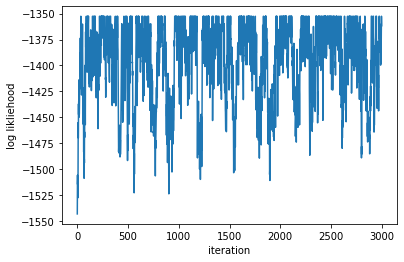

[8.87311486e-04 8.87311486e-04 8.87311486e-04 8.87311486e-04
 9.88464951e-01 8.87311486e-04 7.09849161e-03]
most salient topic: 4
Gensim result: [(0, 0.43223852), (5, 0.5619697)]


In [ ]:
corpus_uncategorized = prepare_text(df_test.Abstract)
corpus_d = corpus_uncategorized[1]

GBS_sampler = GibbsSampler_Predict(n_topics=7,alpha=alpha,beta=beta)
GBS_sampler.initialize(corpus_d)
GBS_sampler.sample(maxiter=3000)
GBS_sampler.plot()

topic_weight = GBS_sampler.theta
dominant_topic = np.argmax(topic_weight)
print(topic_weight)
print("most salient topic:",dominant_topic)
# gensim implementation
topic_dist_inferred = lda_model[corpus[0]]
print("Gensim result:", topic_dist_inferred)